In [7]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection
import pandas as pd
from matplotlib import pylab
import seaborn as sns
import random
random.seed(139)

#from prepare import prepare_data

params = {'xtick.labelsize': 18,
          'ytick.labelsize': 18,
          'axes.titlesize' : 22,
          'axes.labelsize' : 20,
          'legend.fontsize': 18,
          'legend.title_fontsize': 22,
          'figure.titlesize': 24
          }
pylab.rcParams.update(params)


In [8]:
import pandas as pd
import numpy as np
import random
from random import randrange
from random import seed
import time
import datetime
from random import random
from sklearn.preprocessing import StandardScaler, MinMaxScaler





def prepare_data(data: pd.DataFrame, training_data: pd.DataFrame):
    seed(139)
    new_data = data.copy()

    # Create a OHE for blood type
    new_data_encoded = pd.get_dummies(new_data, columns=['blood_type'])

    # Transform the string to a list of symptoms.
    def split(s):
        l = None
        if not pd.isna(s):
            l = s.split(';')
        else:
            l = ['NaN']
        return l

    # Get every type of symptoms.
    def get_items(df):
        s = set()
        for item in df:
            for value in item:
                s.add(value)
        return list(s)

    symptoms_as_list_df = new_data_encoded['symptoms'].apply(split)
    items = get_items(symptoms_as_list_df)

    # Transform a column containing list to a boolean df
    def boolean_df(item_lists, unique_items):
        bool_dict = {}
        for i, item in enumerate(unique_items):
            bool_dict[item] = item_lists.apply(lambda x: int(item in x))
        return pd.DataFrame(bool_dict)

    symptoms_df = boolean_df(symptoms_as_list_df, items)
    symptoms_df = symptoms_df.drop(['NaN'], axis=1)

    # oin it the training set and drop the old symptoms col
    new_data_encoded2 = new_data_encoded.join(symptoms_df).drop(['symptoms'], axis=1)

    # Convert a string of coordinates to a two columns dataframe

    # Convert a date to a timestamp (int)
    def convert_date(s: str):
        if not pd.isna(s):
            s = s.replace('-','/' )
            return time.mktime(datetime.datetime.strptime(s, "%d/%m/%y").timetuple())

    date_df = pd.DataFrame(new_data_encoded2['pcr_date'].apply(convert_date).to_list(), columns=['date'])
    new_data_encoded3 = new_data_encoded2.join(date_df).drop(['pcr_date'], axis = 1)

    # Drop the address columns
    new_data_final = new_data_encoded3.drop(['address'], axis=1)

    # __________IMPUTATION__________


    # imputation of the PCR_Values
    for i in ['PCR_01', 'PCR_04', 'PCR_05', 'PCR_08', 'PCR_10']:
        new_data_final[i] = new_data_final[i].fillna(training_data[i].median())

    # Imputation of the continuous columns
    cont_cols = ['household_income', 'sugar_levels', 'sport_activity']

    for col in cont_cols:
        new_data_final[col] = new_data_final[col].fillna(training_data[col].median())

    # ____________SCALING________________
    new_data_scaled = new_data_final.copy()

    standard_col = ['household_income',
                    'sport_activity', 'PCR_01',
                    'PCR_04', 'PCR_05', 'PCR_08', 'PCR_10','sugar_levels']

    for col in standard_col:
        std_scaler = StandardScaler()
        std_scaler.fit(training_data[[col]])
        new_data_scaled[col] = std_scaler.transform(new_data_final[[col]])

    # ________ADDING NEW FEATURES________
    r = pd.DataFrame(np.sqrt(new_data_scaled.PCR_05**2+new_data_scaled.sugar_levels**2), columns=['radial_distance_pcr5_sugar'])
    new_data_scaled = new_data_scaled.join(r)

    covid_symptoms = pd.DataFrame(new_data_scaled.sore_throat|new_data_scaled.shortness_of_breath|new_data_scaled.cough, columns=['covid_symptoms'])
    df_final = new_data_scaled.join(covid_symptoms)





    return df_final.drop([ 'age', 'sex', 'weight', 'num_of_siblings',
                           'happiness_score', 'conversations_per_day',
                           'PCR_02', 'PCR_03',
                           'PCR_06', 'PCR_07',  'PCR_09',
                           'sore_throat', 'low_appetite', 'cough','shortness_of_breath'
                             ,'current_location' ,'date'], axis = 1).replace({'High': 1, 'Low': -1,True: 1, False:-1})

Importing data

In [3]:

df_train = pd.read_csv('df_train.csv')
df = pd.read_csv('df_train.csv')
df_train_preprocessed = prepare_data(df,df_train)
df_test = pd.read_csv('df_test.csv')
df_test_preprocessed = prepare_data(df_test,df_train)

Creating a new DataFrame with only PCR_08 and PCR_10

In [4]:
df_pcr8_10 = df_train_preprocessed[['PCR_08','PCR_10', 'risk']]
df_pcr8_10

PCR_08    PCR_10  risk
0     1.250214  1.069521     1
1     0.309057 -1.982494    -1
2     0.868399 -1.935724    -1
3    -0.051202  0.940578     1
4     0.919983 -0.713446     1
...        ...       ...   ...
1995 -2.006741 -0.475438    -1
1996  0.568287 -1.113933    -1
1997  1.119245  0.893439     1
1998 -2.033283 -0.313543    -1
1999  0.515382  1.138589    -1

[2000 rows x 3 columns]

Text(-2.5, 5, 'Bivariate Analysis of PCR_08 and PCR_10')

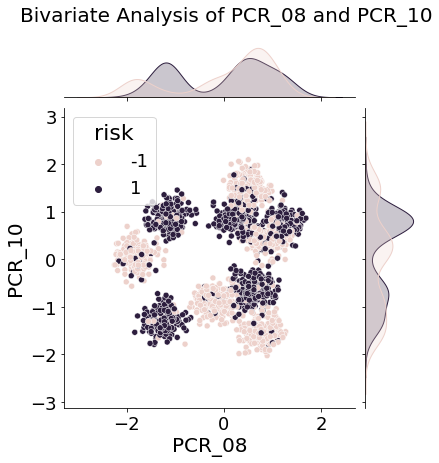

In [5]:
sns.jointplot(data=df_pcr8_10,x='PCR_08',y='PCR_10', hue='risk')
plt.text(-2.5,5, 'Bivariate Analysis of PCR_08 and PCR_10', fontsize = 20)

K-nearest neighbor classifier

In [10]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(1)
knn.fit(df_pcr8_10[['PCR_08','PCR_10']],df_pcr8_10['risk'])

KNeighborsClassifier(n_neighbors=1)

In [11]:
def visualize_clf(clf, X, Y, title,
                  xlabel, ylabel,
                  marker_size=80,
                  grid_length=300,
                  linewidths=None):
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap

    # Make sure labels are 0 and 1
    Y = np.ravel(Y).astype(int)
    labels = set(Y)
    assert len(labels) == 2, "Can only visualize two unique labels"

    if labels == set([-1,1]):
        Y = (Y + 1) // 2
        labels = set(Y)

    assert labels == set([0,1]), "Could not handle given labels"

    plt.figure(figsize=(8, 8))

    # Parameters
    n_classes = 2
    markers = ["D", "o"]
    palette = sns.color_palette("hls", 2)
    custom_cmap = ListedColormap(palette.as_hex())
    #plot_step = 0.02

    x_delta = np.abs(X[:, 0].max() - X[:, 0].min()) * 0.1
    y_delta = np.abs(X[:, 1].max() - X[:, 1].min()) * 0.1
    x_min, x_max = X[:, 0].min() - x_delta, X[:, 0].max() + x_delta
    y_min, y_max = X[:, 1].min() - y_delta, X[:, 1].max() + y_delta
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_length),
                         np.linspace(y_min, y_max, grid_length))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    cs = plt.contourf(xx, yy, Z, cmap=custom_cmap, alpha=0.35)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.75)

    # Plot the training points
    for i, color, marker in zip(labels, palette, markers):
        idx = np.where(Y == i)
        plt.scatter(X[idx, 0], X[idx, 1], color=color,
                    marker=marker,
                    edgecolor='white', s=marker_size,
                    linewidths=linewidths)

    plt.title(title, fontsize=20)
    plt.axis("tight")
    plt.show()


Plotting the decision region of the 1-NN Classifier.

C:\Users\gabrieles\Miniconda3\envs\cs236781-hw\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


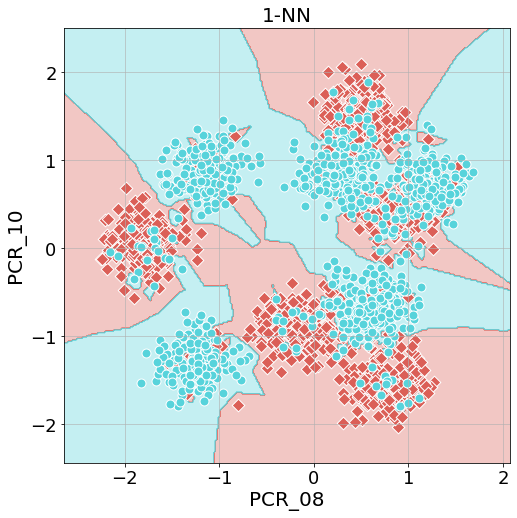

In [12]:
visualize_clf(knn,df_pcr8_10[['PCR_08','PCR_10']].values, df_pcr8_10['risk'].values,'1-NN', 'PCR_08', 'PCR_10')

Cross-validation over k using as features PCR_08 and PCR_10

In [13]:
#Importing the cross-validation function
from sklearn.model_selection import cross_validate
k_list = list(range(1, 20, 1)) + list(range(20, 500, 10))

#fitting for several K a KNN classifier
validation_accuracies = []
train_accuracies = []
for k in k_list:
    knn = KNeighborsClassifier(k)
    cv_results = cross_validate(knn,df_pcr8_10[['PCR_08','PCR_10']], df_pcr8_10['risk'],cv=8, return_train_score=True)
    validation_score = cv_results['test_score'].mean()
    train_score = cv_results['train_score'].mean()
    validation_accuracies.append(validation_score)
    train_accuracies.append(train_score)


In [20]:
max_index_test = np.argmax(validation_accuracies)
max_test = np.max(validation_accuracies)
best_k = k_list[max_index_test]
print(f'Best k: {best_k}')
print(f'Best accuracy on training set: {train_accuracies[max_index_test]}')
print(f'Best accuracy on validation set: {validation_accuracies[max_index_test]}')

Best k: 200
Best accuracy on training set: 0.8711428571428572
Best accuracy on validation set: 0.8725


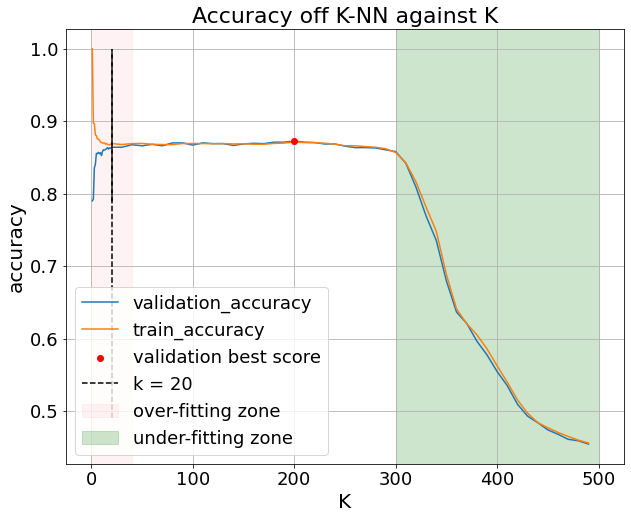

In [21]:
plt.figure(figsize=[10,8])
plt.plot(k_list,validation_accuracies)
plt.plot(k_list, train_accuracies)
plt.scatter([best_k], [max_test],zorder=10, c = 'red')
plt.vlines(20,0.49,1,colors=['black'],linestyles='dashed')
plt.xlabel('K')
plt.axvspan(0,40,0,1, color='pink', alpha=0.2)
plt.axvspan(300,500,0,1, color='green', alpha=0.2)
plt.legend(['validation_accuracy','train_accuracy','validation best score', 'k = 20','over-fitting zone', 'under-fitting zone'])
plt.ylabel('accuracy')
plt.grid()
plt.vlines(20,0.79,1,colors=['black'],linestyles='dashed')
plt.title('Accuracy off K-NN against K')
plt.show()

Test accuracy with the best k: 0.826


C:\Users\gabrieles\Miniconda3\envs\cs236781-hw\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


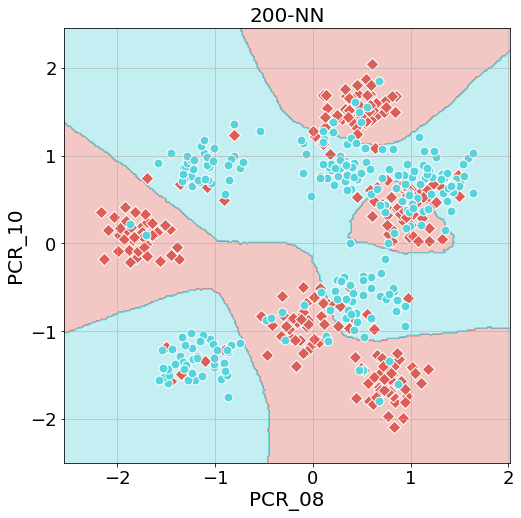

In [23]:
best_knn = KNeighborsClassifier(best_k).fit(df_pcr8_10[['PCR_08','PCR_10']],df_pcr8_10['risk'])
best_score = best_knn.score(df_test_preprocessed[['PCR_08','PCR_10']],df_test_preprocessed['risk'])
print(f'Test accuracy with the best k: {best_score}')
visualize_clf(best_knn,df_test_preprocessed[['PCR_08','PCR_10']].values,df_test_preprocessed['risk'].values,'200-NN','PCR_08','PCR_10')

Cross validation over k using all of the features

In [24]:
#Splitting our df into samples and target dataframes.
X = df_train_preprocessed.drop(columns=['risk','covid','spread'])
Y = df_train_preprocessed['risk']

Visualisation of X and Y

In [25]:
X.head()

Unnamed: 0  patient_id  household_income  sugar_levels  sport_activity  \
0         454        4264         -0.588436     -1.112545       -1.117262   
1         316        7409          0.486509     -1.770265        0.688684   
2        2172        2925          1.073119      0.148085        1.591657   
3        1315        7186         -0.938497     -0.235585        1.591657   
4        1392        3464         -0.099721      0.257705       -1.117262   

     PCR_01    PCR_04    PCR_05    PCR_08    PCR_10  ...  blood_type_A-  \
0 -1.300414 -0.071272  0.875032  1.250214  1.069521  ...              0   
1 -0.532796 -1.570379 -1.694149  0.309057 -1.982494  ...              0   
2 -0.388817 -0.816205  1.116547  0.868399 -1.935724  ...              0   
3 -0.363205 -0.515329 -1.466894 -0.051202  0.940578  ...              0   
4 -0.022263  0.846780 -1.223078  0.919983 -0.713446  ...              0   

   blood_type_AB+  blood_type_AB-  blood_type_B+  blood_type_B-  \
0               0               0              0              0   
1               0               0              0              0   
2               0               0              0              0   
3               0               0              0              0   
4               0               0              0              0   

   blood_type_O+  blood_type_O-  fever  radial_distance_pcr5_sugar  \
0              1              0      0                    1.415429   
1              1              0      0                    2.450302   
2              1              0      0                    1.126324   
3              1              0      0                    1.485691   
4              0              0      0                    1.249933   

   covid_symptoms  
0               0  
1               0  
2               0  
3               0  
4               1  

[5 rows x 21 columns]

In [26]:
Y.head()

0    1
1   -1
2   -1
3    1
4    1
Name: risk, dtype: int64

In [27]:
from sklearn.model_selection import cross_validate
k_list = list(range(1, 20, 1)) + list(range(20, 500, 10))

validation_accuracies = []
train_accuracies = []

for k in k_list:
    knn = KNeighborsClassifier(k)
    cv_results = cross_validate(knn,X, Y,cv=8, return_train_score=True)
    validation_score = cv_results['test_score'].mean()
    train_score = cv_results['train_score'].mean()
    validation_accuracies.append(validation_score)
    train_accuracies.append(train_score)

In [30]:
max_index_test = np.argmax(validation_accuracies)
max_test = np.max(validation_accuracies)
best_k = k_list[max_index_test]

print(f'Best k: {best_k}')
print(f'Best accuracy on training set: {train_accuracies[max_index_test]}')
print(f'Best accuracy on validation set: {validation_accuracies[max_index_test]}')

Best k: 1
Best accuracy on training set: 1.0
Best accuracy on validation set: 0.5195000000000001


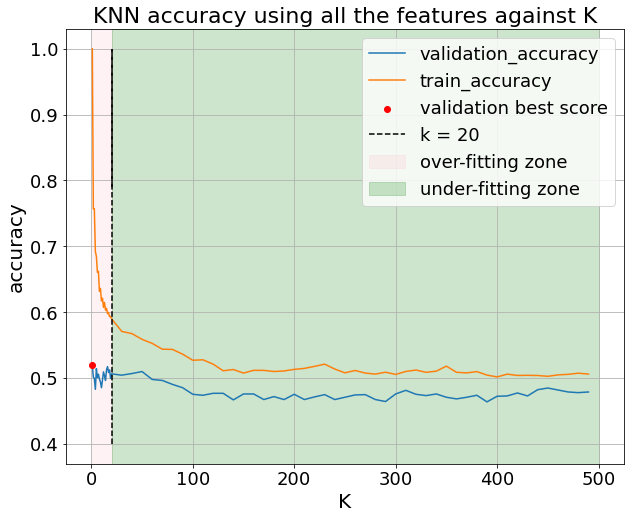

In [32]:
plt.figure(figsize=[10,8])
plt.plot(k_list,validation_accuracies)
plt.plot(k_list, train_accuracies)
plt.scatter([best_k], [max_test],zorder=10, c = 'red')
plt.vlines(20,0.40,1,colors=['black'],linestyles='dashed')
plt.axvspan(0,20,0,1, color='pink', alpha=0.2)
plt.axvspan(20,500,0,1, color='green', alpha=0.2)
plt.legend(['validation_accuracy','train_accuracy','validation best score', 'k = 20', 'over-fitting zone', 'under-fitting zone'])
plt.xlabel('K')
plt.ylabel('accuracy')
plt.grid()
plt.vlines(20,0.79,1,colors=['black'],linestyles='dashed')
plt.title('KNN accuracy using all the features against K')
plt.show()

As we can see the 5 most correlated features to covid are 'covid_symptoms', 'sport_activity', 'PCR_01', 'PCR_04' and 'sugar_levels'
Reminder: covid_symptoms is a binary feature that is one if the patient has at least one of the following symptoms: sore_throat, cough and shortness_of_breath.

In [33]:
df_train_preprocessed.corr()['covid'].abs().sort_values(ascending=False).head(6)

covid             1.000000
covid_symptoms    0.741340
sport_activity    0.209082
PCR_01            0.169038
PCR_04            0.101333
sugar_levels      0.075169
Name: covid, dtype: float64

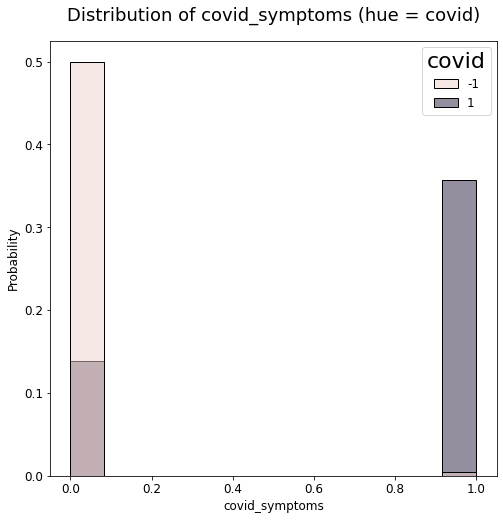

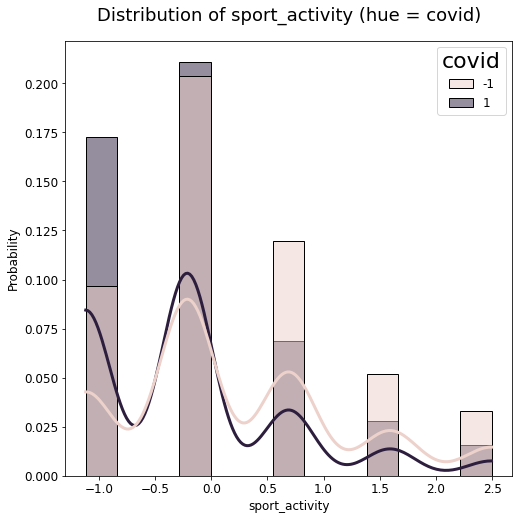

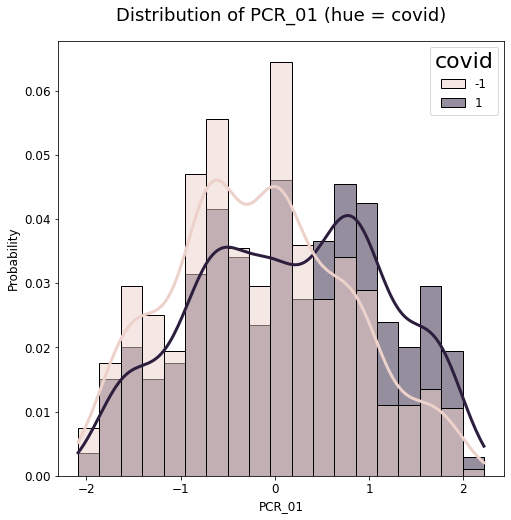

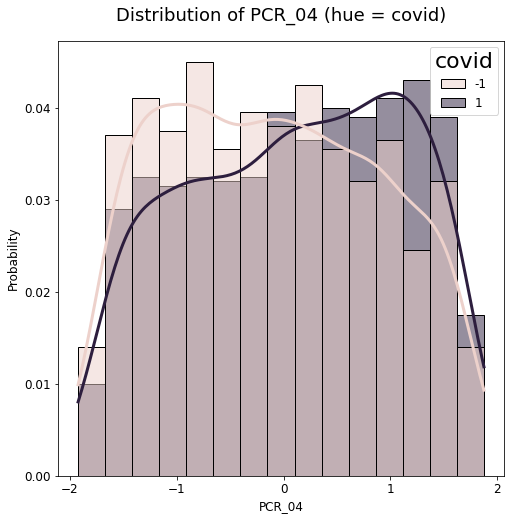

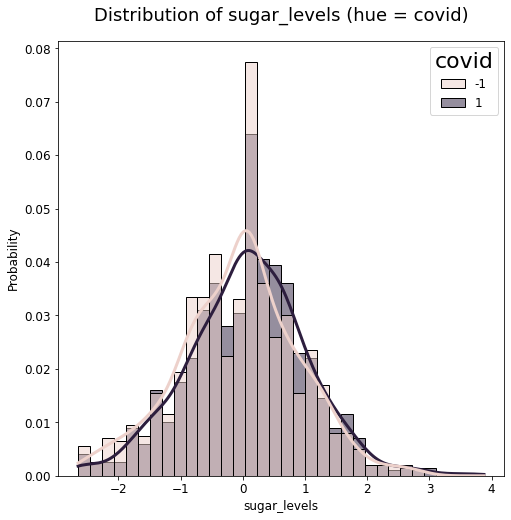

In [38]:
params = {'xtick.labelsize': 12,
          'ytick.labelsize': 12,
          'axes.titlesize' : 18,
          'axes.labelsize' : 12,
          'legend.fontsize': 12,
          'legend.title_fontsize': 22,
          'figure.titlesize': 24
          }
pylab.rcParams.update(params)

for feature in ['covid_symptoms', 'sport_activity', 'PCR_01', 'PCR_04', 'sugar_levels']:
    plt.figure(figsize=[8,8])
    is_float = "float64" == df_train_preprocessed[feature].dtype.name
    sns.histplot(data=df_train_preprocessed, x=feature,
                 line_kws={"linewidth":3},
                 hue='covid', stat='probability', kde=is_float)
    plt.title(f'Distribution of {feature} (hue = covid)', pad = 20)
params = {'xtick.labelsize': 18,
          'ytick.labelsize': 18,
          'axes.titlesize' : 22,
          'axes.labelsize' : 20,
          'legend.fontsize': 18,
          'legend.title_fontsize': 22,
          'figure.titlesize': 24
          }
pylab.rcParams.update(params)

Let's compute the 10 most correlated features with covid (we decided to drop the column "patient_id" as it is used only to uniquely identify the patients, and any interaction with any other feature or label should be disregarded as any potential pattern is merely artificial)

In [41]:
df_train_preprocessed.drop(columns=['patient_id']).corr()['covid'].abs().sort_values(ascending=False)[1:11]

covid_symptoms      0.741340
sport_activity      0.209082
PCR_01              0.169038
PCR_04              0.101333
sugar_levels        0.075169
blood_type_A+       0.068121
blood_type_O+       0.066160
blood_type_A-       0.055900
fever               0.035015
household_income    0.022060
Name: covid, dtype: float64

Now we will train a decision three with ID3 algorithm

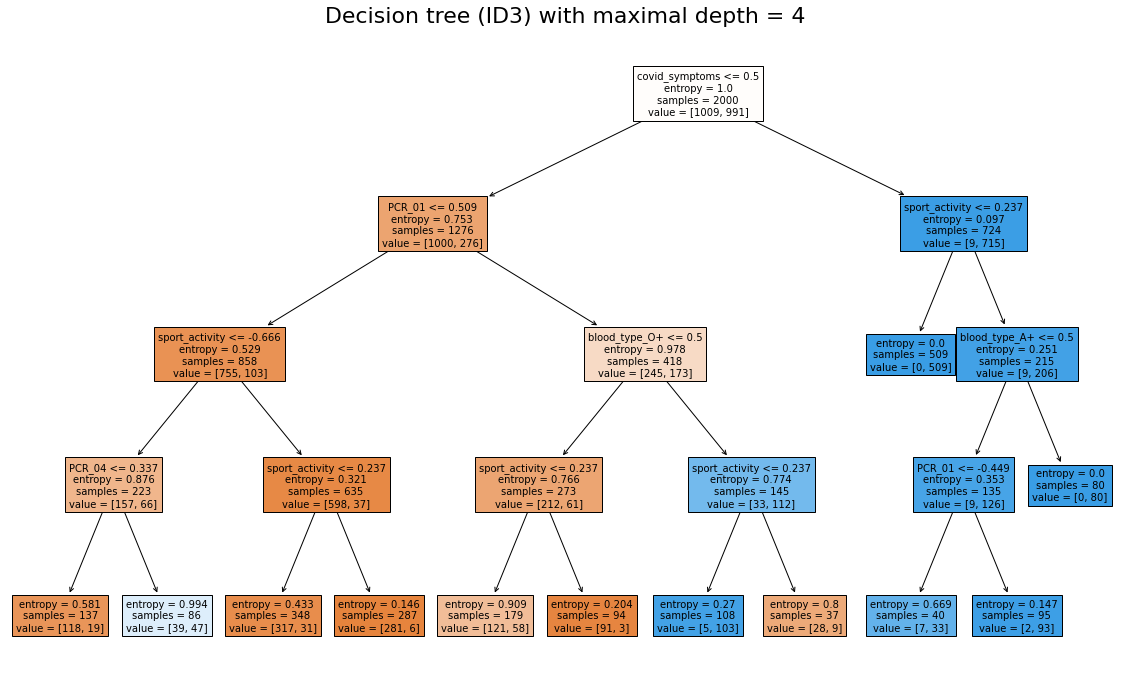

The model score is: 0.9105


In [42]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

col_to_remove = ['spread', 'risk', 'covid', 'patient_id']

ID3 = DecisionTreeClassifier(criterion='entropy', max_depth=4)
ID3.fit(df_train_preprocessed.drop(columns=col_to_remove, axis = 1), y=df_train_preprocessed[['covid']])
accuracy = ID3.score(df_train_preprocessed.drop(columns=col_to_remove, axis = 1), y=df_train_preprocessed[['covid']])
plt.figure(figsize=(20,12))
plot_tree(ID3, fontsize=10, feature_names=df_train_preprocessed.drop(columns=col_to_remove, axis = 1).columns, filled= True)
plt.title('Decision tree (ID3) with maximal depth = 4')
plt.show()


print(f'The model score is: {accuracy}')




In [43]:
df_train_preprocessed : pd.DataFrame
depth1 = df_train_preprocessed.where(df_train_preprocessed.covid_symptoms ==1).dropna()
depth12 = depth1.where(df_train_preprocessed.sport_activity <= 0.237).dropna()
sum(depth12['covid'] == 1)/ len(depth12['covid'])


1.0

In [50]:
depth1 = df_train_preprocessed.where(df_train_preprocessed.covid_symptoms ==1.0).dropna()
depth12 = depth1.where(df_train_preprocessed.sport_activity <= 0.237).dropna()
depth12

Unnamed: 0  patient_id  household_income  sugar_levels  sport_activity  \
4         1392.0      3464.0         -0.099721      0.257705       -1.117262   
13         811.0      2243.0         -0.283703     -0.619255       -1.117262   
14        2361.0      5404.0          2.672965      2.066436       -1.117262   
15        2178.0      4638.0          0.951607      1.134666       -1.117262   
18           1.0      6236.0         -0.241040     -0.345205       -0.214289   
...          ...         ...               ...           ...             ...   
1974       399.0      3266.0         -0.243326     -0.235585       -1.117262   
1977      2001.0      2185.0          0.929514     -0.619255       -0.214289   
1978      2467.0      6119.0         -0.243326      0.476945       -1.117262   
1987      2099.0      4288.0          0.339932      0.038465       -0.214289   
1989      1443.0      3597.0         -0.389598      0.202895       -0.214289   

        PCR_01    PCR_04    PCR_05    PCR_08    PCR_10  ...  blood_type_A-  \
4    -0.022263  0.846780 -1.223078  0.919983 -0.713446  ...            0.0   
13    0.855651 -0.951465 -0.601238 -1.578273 -1.270956  ...            0.0   
14    0.925612  0.186692  0.156804  0.240083  1.584517  ...            0.0   
15   -0.444088  0.347659  0.482519 -1.111659  0.786341  ...            0.0   
18   -0.460835 -0.796615 -0.675281  0.308196 -1.643471  ...            0.0   
...        ...       ...       ...       ...       ...  ...            ...   
1974  0.673892 -1.607628 -1.783753  0.371720  1.037055  ...            0.0   
1977 -0.379152  0.666758 -0.224176 -1.759409 -0.121024  ...            0.0   
1978  1.859377 -0.273972 -0.914074 -1.222279 -1.394440  ...            1.0   
1987 -0.462328 -0.919917  0.566177 -1.634038 -1.158622  ...            0.0   
1989  1.016157 -0.755288  1.565535  1.080424  0.485254  ...            0.0   

      blood_type_AB+  blood_type_AB-  blood_type_B+  blood_type_B-  \
4                0.0             0.0            0.0            0.0   
13               0.0             0.0            0.0            0.0   
14               0.0             0.0            0.0            0.0   
15               0.0             0.0            0.0            0.0   
18               0.0             0.0            0.0            0.0   
...              ...             ...            ...            ...   
1974             0.0             0.0            0.0            0.0   
1977             0.0             0.0            0.0            0.0   
1978             0.0             0.0            0.0            0.0   
1987             0.0             0.0            0.0            0.0   
1989             0.0             0.0            0.0            0.0   

      blood_type_O+  blood_type_O-  fever  radial_distance_pcr5_sugar  \
4               0.0            0.0    0.0                    1.249933   
13              0.0            0.0    0.0                    0.863113   
14              0.0            0.0    0.0                    2.072377   
15              0.0            0.0    0.0                    1.233000   
18              0.0            0.0    0.0                    0.758400   
...             ...            ...    ...                         ...   
1974            0.0            0.0    0.0                    1.799242   
1977            1.0            0.0    0.0                    0.658583   
1978            0.0            0.0    0.0                    1.031023   
1987            1.0            0.0    0.0                    0.567482   
1989            1.0            0.0    0.0                    1.578628   

      covid_symptoms  
4                1.0  
13               1.0  
14               1.0  
15               1.0  
18               1.0  
...              ...  
1974             1.0  
1977             1.0  
1978             1.0  
1987             1.0  
1989             1.0  

[509 rows x 24 columns]

Model selection

The best parameters are {'max_depth': 6, 'min_samples_leaf': 0.0001} (min samples: 1.0) and whose mean validation accuracy is 0.915


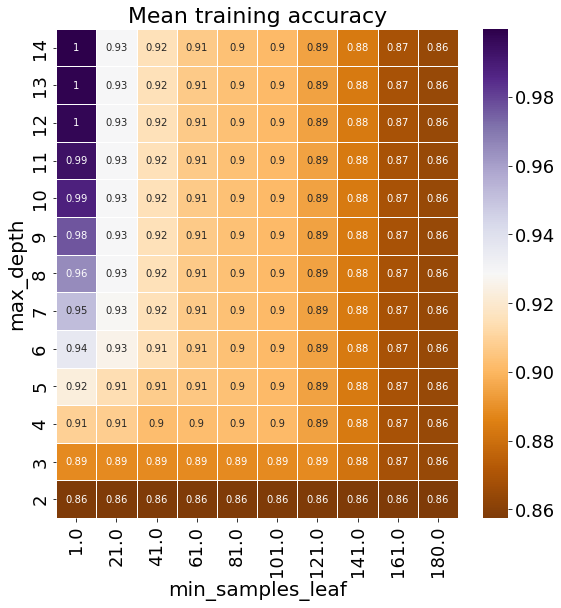

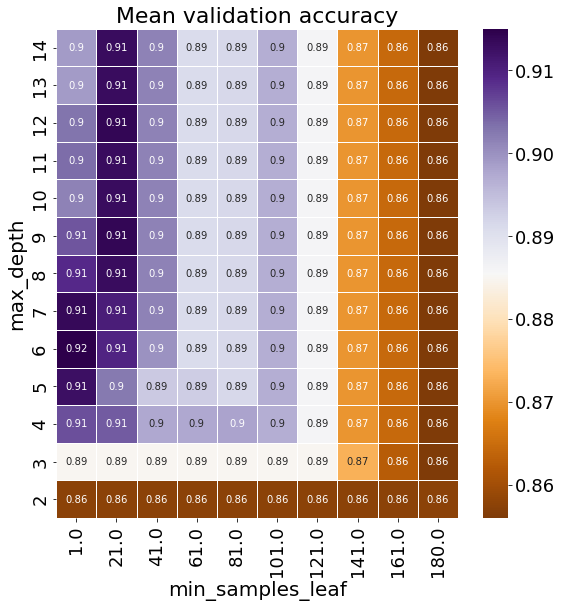

In [109]:
from sklearn.model_selection import GridSearchCV
max_depths = np.arange(2,15,1)
min_leaf = np.around(np.linspace(0.0001,0.09 , 10), 5)

params = {
    'max_depth' : max_depths,
    'min_samples_leaf': min_leaf
}
tree = DecisionTreeClassifier(criterion='entropy')
gs = GridSearchCV(tree,params,cv=8, scoring='accuracy', return_train_score=True)
gs.fit(df_train_preprocessed.drop(columns=col_to_remove, axis = 1).values, y=df_train_preprocessed[['covid']].values)

test_accuracy_values = np.flip(gs.cv_results_["mean_test_score"].reshape(len(max_depths),len(min_leaf)),0)
best_params = gs.best_params_
best_score = gs.best_score_

train_accuracy_values = np.flip(gs.cv_results_["mean_train_score"].reshape(len(max_depths),len(min_leaf)),0)

print(f'The best parameters are {best_params} (min samples: {np.ceil(best_params["min_samples_leaf"]*len(df_train_preprocessed))}) and whose mean validation accuracy is {best_score}')

plt.figure(figsize=(9,9))
plt.title('Mean training accuracy')
sns.heatmap(train_accuracy_values, annot = True, xticklabels=np.ceil(min_leaf*len(df_train_preprocessed)), yticklabels=np.flip(max_depths),linewidths = 1, cmap='PuOr').set(xlabel='min_samples_leaf', ylabel='max_depth')

plt.figure(figsize=(9,9))
plt.title('Mean validation accuracy')
sns.heatmap(test_accuracy_values, annot = True, xticklabels=np.ceil(min_leaf*len(df_train_preprocessed)), yticklabels=np.flip(max_depths),linewidths = 1, cmap='PuOr').set(xlabel='min_samples_leaf', ylabel='max_depth');

Let's train our model with optimal parameters that we found for our validation set

In [111]:
opt_params = best_params
optimal_tree = DecisionTreeClassifier(criterion='entropy', **opt_params)
optimal_tree.fit(df_train_preprocessed.drop(columns=col_to_remove, axis = 1).values, y=df_train_preprocessed[['covid']].values)

X_test = df_test_preprocessed.drop(columns=col_to_remove, axis = 1).values
y_test = df_test_preprocessed[['covid']].values

print(f'Score of the decision tree with optimal hyper parameters: {optimal_tree.score(X_test, y_test)}')

Score of the decision tree with optimal hyper parameters: 0.93


Part 3: Linear SVM and Polynomial kernel.

In [112]:
from sklearn.base import BaseEstimator, ClassifierMixin
class SoftSVM(BaseEstimator, ClassifierMixin):
    """
    Custom C-Support Vector Classification.
    """
    def __init__(self, C: float, lr: float = 1e-5, batch_size = 32):
        """
        Initialize an instance of this class.
        ** Do not edit this method **

        :param C: inverse strength of regularization. Must be strictly positive.
        :param lr: the SGD learning rate (step size)
        """
        self.C = C
        self.lr = lr
        self.batch_size = batch_size
        self.w = None
        self.b = 0.0
        self.losses = []
        self.accuracies = []

    # Initialize a random weight vector
    def init_solution(self, n_features: int):
        """
        Randomize an initial solution (weight vector)
        ** Do not edit this method **

        :param n_features:
        """
        self.w = np.random.randn(n_features)
        self.b = 0.0

    @staticmethod
    def loss(w, b: float, C: float, X, y):
        """
        Compute the SVM objective loss. CACA

        :param w: weight vector for linear classification; array of shape (n_features,)
        :param b: bias scalar for linear classification
        :param C: inverse strength of regularization. Must be strictly positive.
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: the Soft SVM objective loss (float scalar)
        """
        margins = (X.dot(w) + b).reshape(-1, 1)
        hinge_inputs = np.multiply(margins, y.reshape(-1, 1))
        norm = np.linalg.norm(w)

        # TODO: complete the loss calculation
        max_in = np.max(np.concatenate([1 - hinge_inputs, np.zeros_like(hinge_inputs)],axis=1), axis=1)
        loss = norm ** 2 + C*np.sum(max_in)

        return loss

    @staticmethod
    def subgradient(w, b: float, C: float, X, y):
        """
        Compute the (analytical) SVM objective sub-gradient.

        :param w: weight vector for linear classification; array of shape (n_features,)
        :param b: bias scalar for linear classification
        :param C: inverse strength of regularization. Must be strictly positive.
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: a tuple with (the gradient of the weights, the gradient of the bias)
        """
        # TODO: calculate the analytical sub-gradient of soft-SVM w.r.t w and b

        def f(z):
            if z >= 1:
                return 0
            else:
                return -1
        margins = (X.dot(w) + b).reshape(-1, 1)
        hinge_inputs = np.multiply(margins, y.reshape(-1, 1))

        hinge_inputs = np.array([f(z) for z in hinge_inputs]).reshape(-1,1)

        sum_inputs = (hinge_inputs * y) * X

        g_w = 2*w + C * np.sum(sum_inputs, axis=0)
        g_b = C * np.sum(hinge_inputs*y)

        return g_w, g_b

    def fit_with_logs(self, X, y, max_iter: int = 2000, keep_losses: bool = True):
        """
        Fit the model according to the given training data.

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets (+1 and -1); array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        :param keep_losses:
        :return: the training losses and accuracies during training
        """
        # Initialize learned parameters
        self.init_solution(X.shape[1])

        losses = []
        accuracies = []

        if keep_losses:
            losses.append(self.loss(self.w, self.b, self.C, X, y))
            accuracies.append(self.score(X, y))

        # Iterate over batches
        for iter in range(0, max_iter):
            start_idx = (iter * self.batch_size) % X.shape[0]
            end_idx = min(X.shape[0], start_idx + self.batch_size)
            batch_X = X[start_idx: end_idx]
            batch_y = y[start_idx: end_idx]

            # TODO: Compute the (sub)gradient of the current *batch*
            g_w, g_b = SoftSVM.subgradient(self.w, self.b,self.C,batch_X,batch_y)

            # Perform a (sub)gradient step
            # TODO: update the learned parameters correctly
            self.w -= self.lr * g_w
            self.b -= self.lr * g_b

            if keep_losses:
                losses.append(self.loss(self.w, self.b, self.C, X, y))
                accuracies.append(self.score(X, y))

        self.losses.extend(losses)
        self.accuracies.extend(accuracies)
        return losses, accuracies

    def fit(self, X, y, max_iter: int = 2000):
        """
        Fit the model according to the given training data.
        ** Do not edit this method **

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets (+1 and -1); array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        """
        self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

        return self

    def predict(self, X):
        """
        Perform classification on samples in X.

        :param X: samples for prediction; array of shape (n_samples, n_features)
        :return: Predicted class labels for samples in X; array of shape (n_samples,)
                 NOTE: the labels must be either +1 or -1
        """
        # TODO: compute the predicted labels (+1 or -1)
        y_pred = np.sign((X.dot(self.w) + self.b))

        return y_pred

(1000, 2), (1000, 1)


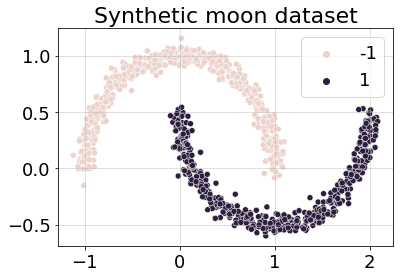

In [115]:

from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(n_samples=1000, shuffle=True, noise=0.05, random_state=139)
y_moons = ((2 * y_moons) - 1)[:, None]
print(f"{X_moons.shape}, {y_moons.shape}")
plt.figure(), plt.grid(alpha=0.5), plt.title("Synthetic moon dataset")
_ = sns.scatterplot(x=X_moons[:, 0], y=X_moons[:, 1], hue=y_moons[:, 0])

In [116]:
def numerical_subgradient(w, b, C, X, y, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = SoftSVM.loss(w_, b, C, X, y)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = SoftSVM.loss(w_, b, C, X, y)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (SoftSVM.loss(w_, b + delta, C, X, y) - orig_objective) / delta
    return g_w, g_b
def compare_gradients(X, y, deltas, C=1, REPEATS=100, figsize=(10, 6)):
    residual_means = []

    for delta in deltas:
        residuals = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad = SoftSVM.subgradient(w, b, C, X, y)[0]
            numeric_grad = numerical_subgradient(w, b, C, X, y, delta=delta)[0]

            residual = np.linalg.norm(numeric_grad - analytic_grad)
            residuals.append(residual)

        residual_means.append(np.mean(residuals))

    plt.figure(figsize=figsize)
    plt.title('Residuals of analytical and numerical gradients', fontsize=22)
    plt.plot(deltas, residual_means, linewidth=3)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('$\delta$', fontsize=18)
    plt.ylabel(r'$\left\Vert \nabla_{w}p_{C}\left(w,b\right) - u_{\delta} \left(w,b\right)\right\Vert$', fontsize=18)

    plt.grid(alpha=0.5)
    plt.show()


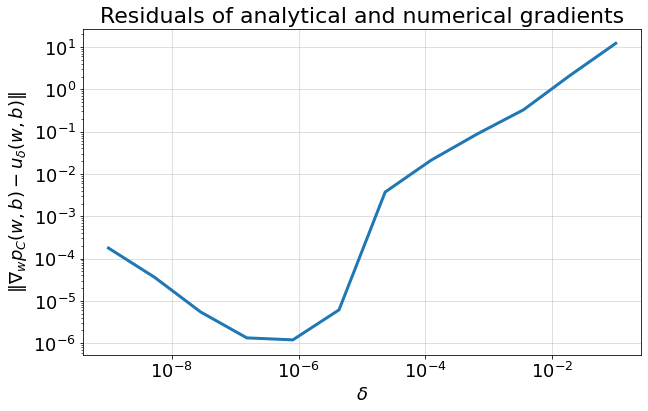

In [117]:
compare_gradients(X_moons, y_moons, deltas=np.logspace(-9, -1, 12))

The best loss was obtained on the 2990-th iteration and is equal to: 326.023357483529
The best accuracy was obtained on the 244-th iteration and is equal to: 0.885


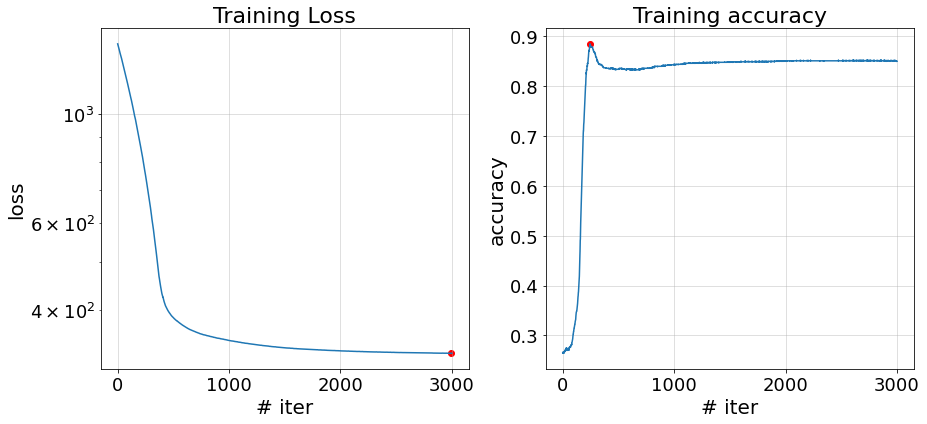

In [124]:

clf = SoftSVM(C=1, lr=0.0002)
losses, accuracies = clf.fit_with_logs(X_moons, y_moons, max_iter=3000)
best_loss_index = np.argmin(losses)
best_acc_index = np.argmax(accuracies)
plt.figure(figsize=(13, 6))
plt.subplot(121), plt.grid(alpha=0.5), plt.title ("Training Loss")
plt.semilogy(losses), plt.xlabel("# iter"), plt.ylabel("loss")
plt.scatter(x=best_loss_index, y=losses[best_loss_index],c = 'red')
plt.subplot(122), plt.grid(alpha=0.5), plt.title ("Training accuracy")
plt.plot(accuracies), plt.xlabel("# iter"), plt.ylabel("accuracy")
plt.scatter(x= best_acc_index, y = accuracies[best_acc_index], c = 'red')
plt.tight_layout()

print(f'The best loss was obtained on the {best_loss_index}-th iteration and is equal to: {losses[best_loss_index]}')
print(f'The best accuracy was obtained on the {best_acc_index}-th iteration and is equal to: {accuracies[best_acc_index]}')

Decision Region of our SVM model

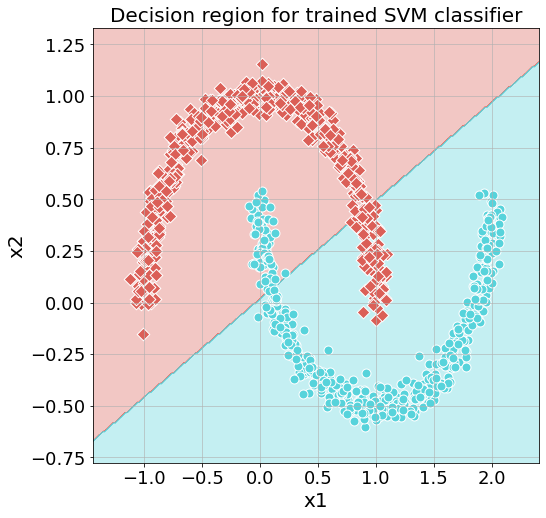

In [125]:
visualize_clf(clf,X_moons,y_moons,'Decision region for trained SVM classifier','x1','x2')

Here we create the df containing only sugar_levels, PCR_05 and spread

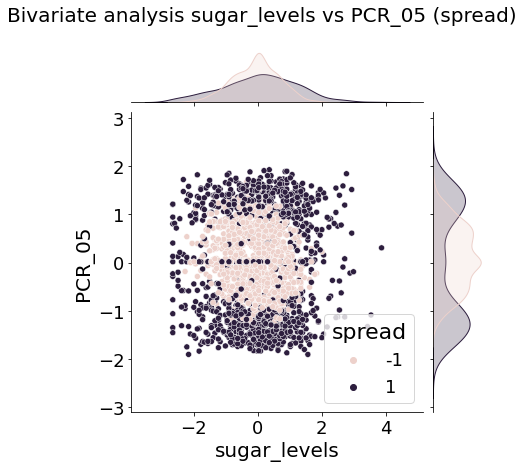

In [127]:
df_sugar_pcr5 = df_train_preprocessed[['sugar_levels', 'PCR_05', 'spread']]

sns.jointplot(data=df_sugar_pcr5,x = 'sugar_levels', y = 'PCR_05', hue = df_sugar_pcr5['spread'])
plt.text(-2.5,5, 'Bivariate analysis sugar_levels vs PCR_05 (spread)', fontsize = 20);

Creation of a pipeline with the feature mapping

for test 1 we got an accuracy of 0.52


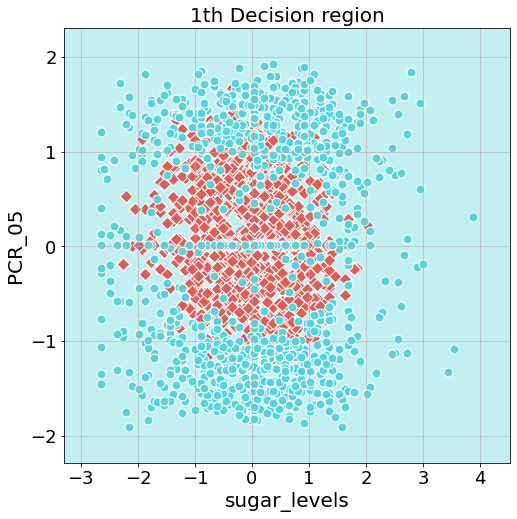

for test 2 we got an accuracy of 0.65


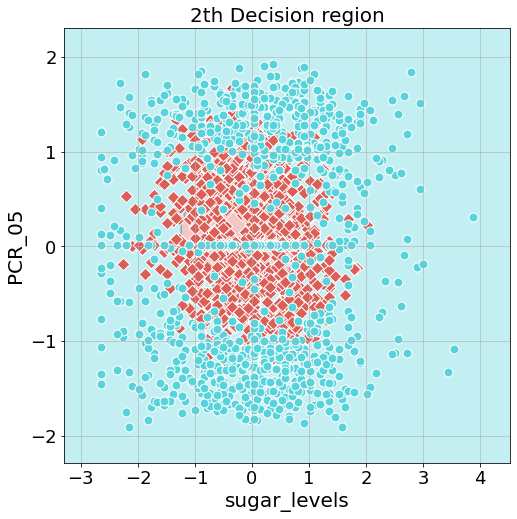

for test 3 we got an accuracy of 0.83


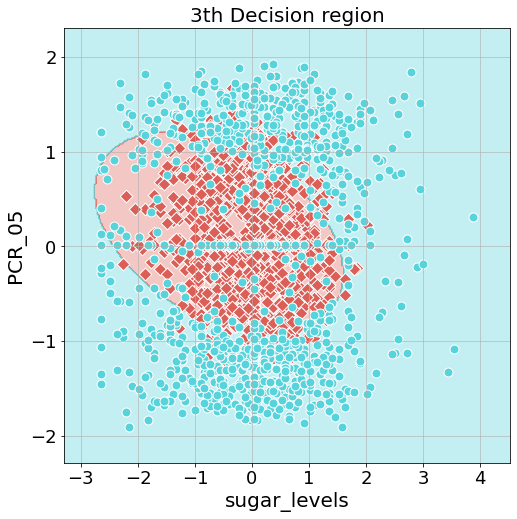

for test 4 we got an accuracy of 0.81


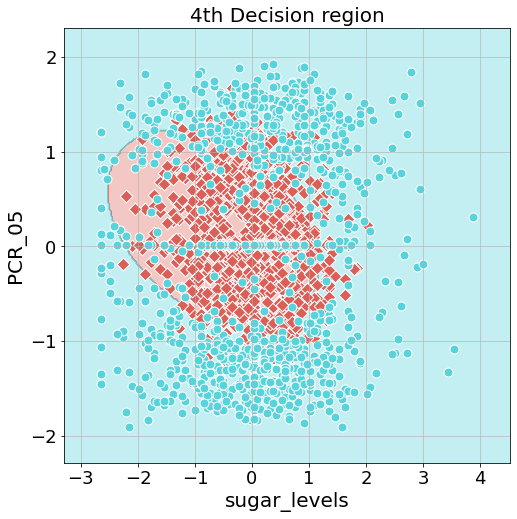

for test 5 we got an accuracy of 0.76


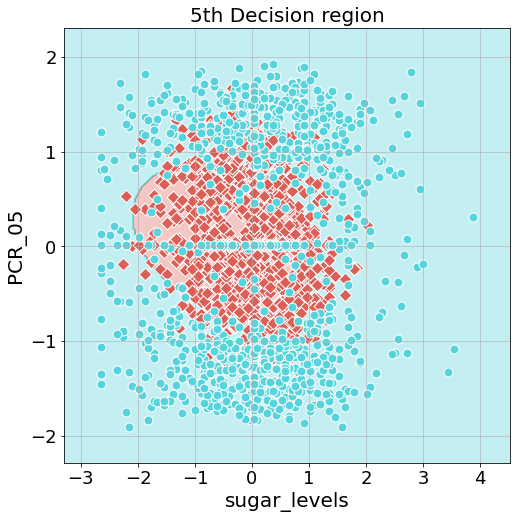

The average accuracy is 0.71 and the standard deviation is 0.11632


In [138]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X_train = df_sugar_pcr5[['sugar_levels','PCR_05']].values
Y_train = df_sugar_pcr5['spread'].values.reshape(-1,1)
pipeline_acc = []
for i in range(1,6):
    svm_clf = Pipeline([('feature_mapping', PolynomialFeatures(degree=2)), ('SVM', SoftSVM(C=1e4, lr=1e-3, batch_size=32))])
    svm_clf.fit(X_train,Y_train ,SVM__max_iter = 10000)
    y_hat = np.array(svm_clf.predict(X_train)).reshape(-1,1)
    y_moons_vec = np.array( Y_train).reshape(-1,1)

    accuracy = np.sum( Y_train == y_hat)/len(y_moons_vec)
    pipeline_acc.append(accuracy)
    print(f'for test {i} we got an accuracy of {accuracy:.2f}')

    visualize_clf(svm_clf, X_train,  Y_train,f'{i}th Decision region','sugar_levels', 'PCR_05')

pipeline_acc = np.array(pipeline_acc)

std = pipeline_acc.std()
mean = pipeline_acc.mean()

print(f'The average accuracy is {mean:.2f} and the standard deviation is {std:.5f}')

Cross Validation over C

In [145]:
from sklearn.model_selection import cross_validate

C_range = np.logspace(-3,3,base = 10, num = 100)
train_scores = np.zeros_like(C_range)
test_scores = np.zeros_like(C_range)
for i, c in enumerate(C_range):
    svm_clf_tune = Pipeline([('feature_mapping', PolynomialFeatures(degree=2)), ('SVM', SoftSVM(C=c, lr=1e-3, batch_size=32))])
    results = cross_validate(svm_clf_tune,X_train, Y_train, cv = 10,return_train_score=True)
    train_scores[i] = results['train_score'].mean()
    test_scores[i] = results['test_score'].mean()

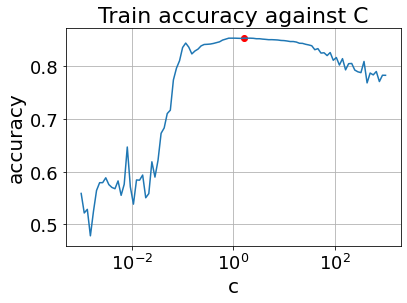

best C for the training set:  1.630 with an accuracy of 0.8538333333333334


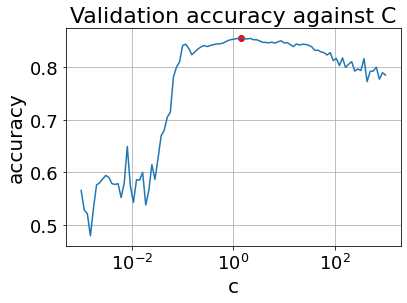

Best C for validation set:  1.417 with an accuracy of 0.8545


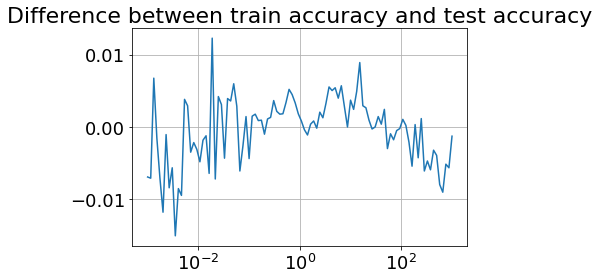

In [146]:

best_train_score_idx = np.argmax(train_scores)
plt.semilogx(C_range,train_scores)
plt.scatter(C_range[best_train_score_idx], train_scores[best_train_score_idx], c = 'red')
plt.grid()
plt.title('Train accuracy against C')
plt.xlabel('c')
plt.ylabel('accuracy')
plt.show()
print(f'best C for the training set: {C_range[best_train_score_idx]: .3f} with an accuracy of {train_scores[best_train_score_idx]}')
best_test_score_idx = np.argmax(test_scores)
plt.semilogx(C_range,test_scores)
plt.scatter(C_range[best_test_score_idx], test_scores[best_test_score_idx], c = 'red')
plt.grid()
plt.title('Validation accuracy against C')
plt.xlabel('c')
plt.ylabel('accuracy')
plt.show()

print(f'Best C for validation set: {C_range[best_test_score_idx]: .3f} with an accuracy of {test_scores[best_test_score_idx]}')

plt.title('Difference between train accuracy and test accuracy')
plt.semilogx(C_range,train_scores - test_scores)
plt.grid()
plt.show()

Training the model on all the training samples with the best C found

Accuracy: 0.87


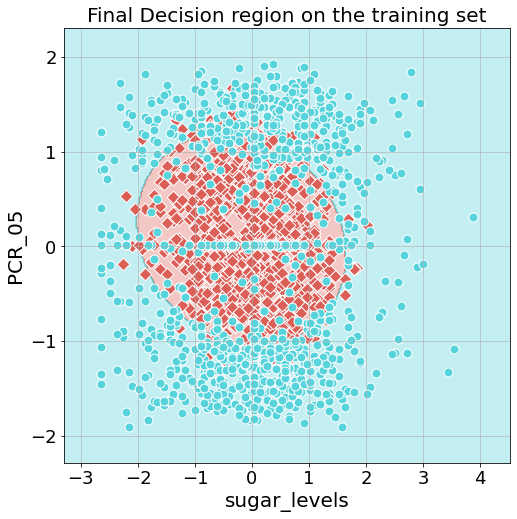

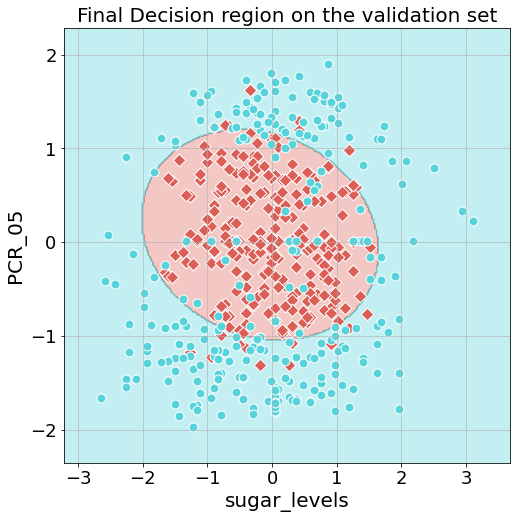

In [147]:
best_C = C_range[best_test_score_idx]
X_test = df_test_preprocessed[['sugar_levels', 'PCR_05']].values
Y_test =  df_test_preprocessed['spread'].values.reshape(-1,1)
svm_clf = Pipeline([('feature_mapping', PolynomialFeatures(degree=2)), ('SVM', SoftSVM(C=best_C, lr=1e-3, batch_size=32))])
svm_clf.fit(X_train,Y_train ,SVM__max_iter = 10000)
y_hat = np.array(svm_clf.predict(X_test)).reshape(-1,1)
y_moons_vec = np.array(Y_test).reshape(-1,1)

accuracy = np.sum( Y_test == y_hat)/len(y_moons_vec)
print(f'Accuracy: {accuracy:.2f}')
visualize_clf(svm_clf, X_train,  Y_train,f'Final Decision region on the training set','sugar_levels', 'PCR_05')
visualize_clf(svm_clf, X_test,  Y_test,f'Final Decision region on the validation set','sugar_levels', 'PCR_05')

Cross validatin of RBF kernel using PCR_08 and PCR_10 to predict risk over $\gamma$

In [148]:
from sklearn.svm import SVC
X_train_rbf = df_train_preprocessed[['PCR_08','PCR_10']].values
Y_train_rbf = df_train_preprocessed['risk'].values
X_test_rbf = df_test_preprocessed[['PCR_08','PCR_10']].values
Y_test_rbf = df_test_preprocessed['risk'].values

accuracy = 0.509


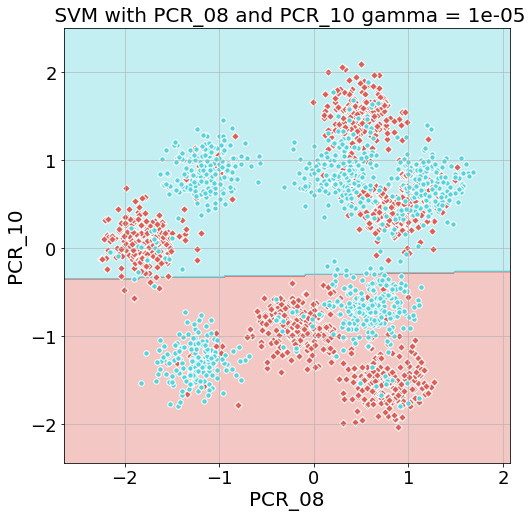

accuracy = 0.5145


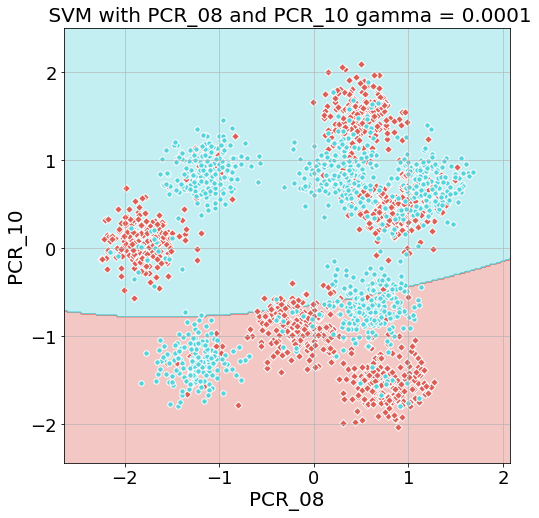

accuracy = 0.6075


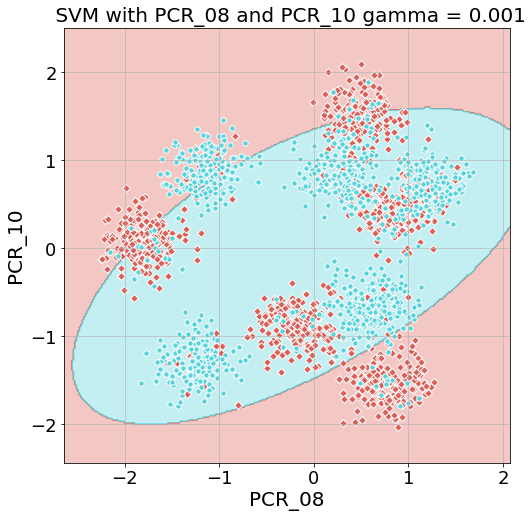

accuracy = 0.7735


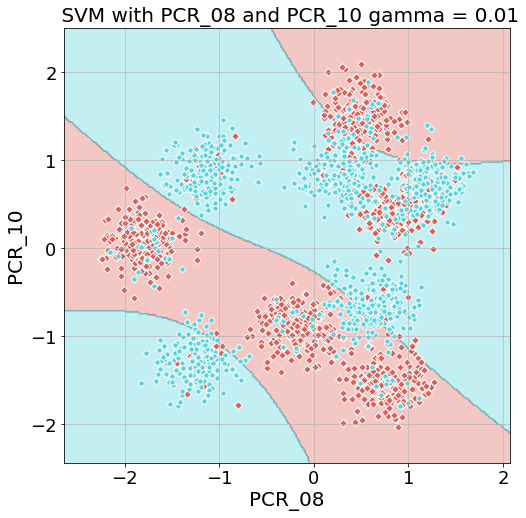

accuracy = 0.8505


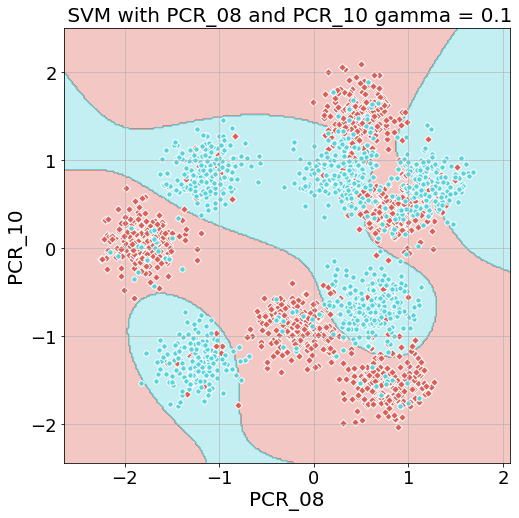

accuracy = 0.8685


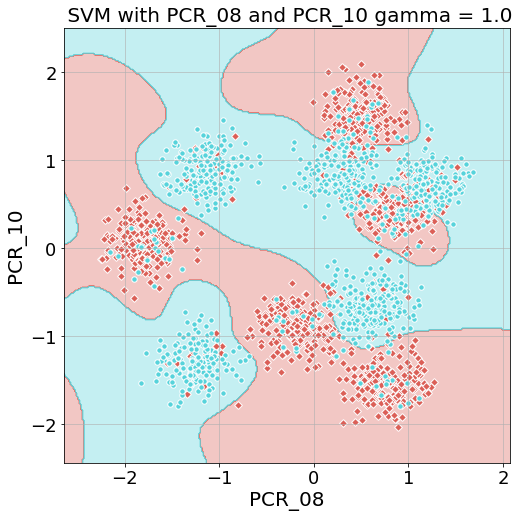

accuracy = 0.889


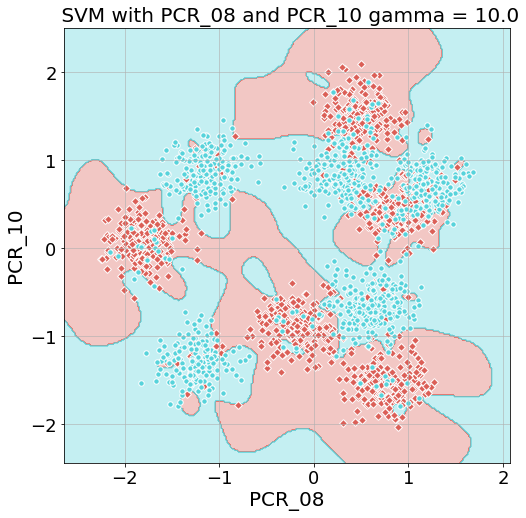

accuracy = 0.991


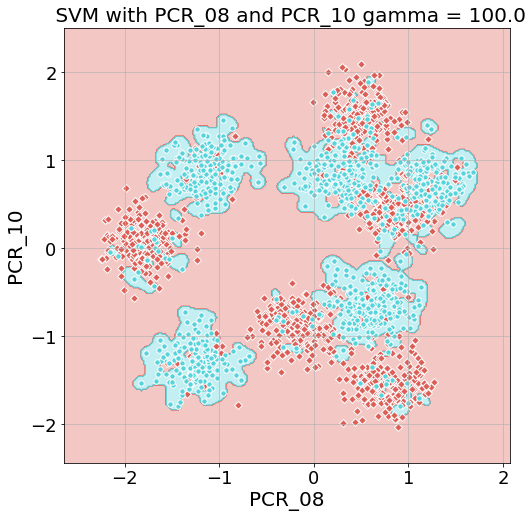

accuracy = 1.0


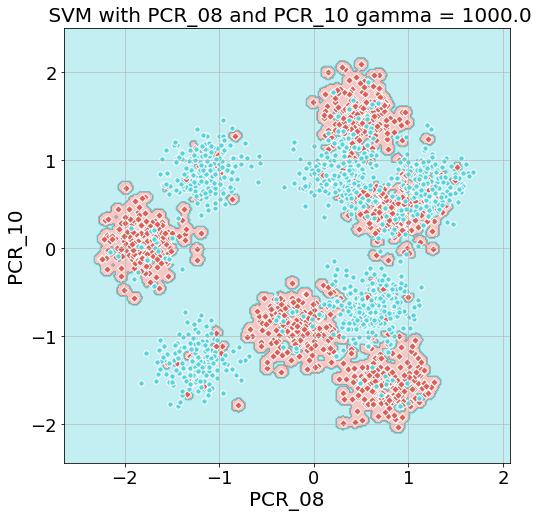

accuracy = 1.0


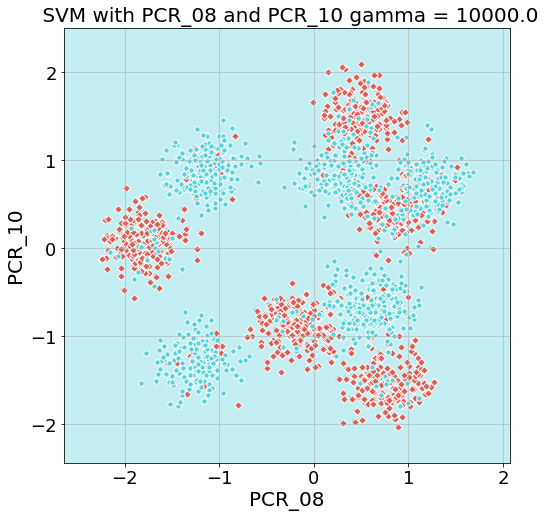

In [149]:
gamma_space = np.logspace(-5, 4, 10)
for i, gamma in enumerate(gamma_space):
    clf = SVC(C=1e4, gamma=gamma)
    clf.fit(X_train_rbf, Y_train_rbf)
    print(f'accuracy = {clf.score(X_train_rbf, Y_train_rbf)}')
    visualize_clf(clf, X_train_rbf, Y_train_rbf,f' SVM with PCR_08 and PCR_10 gamma = {gamma}','PCR_08', 'PCR_10',marker_size=30)

accuracy = 1.0


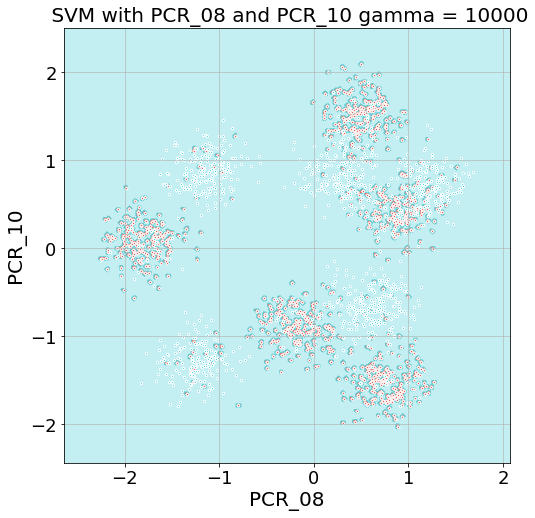

In [150]:
clf = SVC(C=1e4, gamma=10000)
clf.fit(X_train_rbf, Y_train_rbf)
print(f'accuracy = {clf.score(X_train_rbf, Y_train_rbf)}')
visualize_clf(clf, X_train_rbf, Y_train_rbf,f' SVM with PCR_08 and PCR_10 gamma = {10000}','PCR_08', 'PCR_10',marker_size=5)

In [151]:
clf.get_params()

{'C': 10000.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 10000,
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [152]:
svc = SVC()

C_range = [0.01, 0.02, 0.03]
gamma_range = np.linspace(7.5, 8.5, 10)
params = {
    'C': C_range,
    'gamma': gamma_range
}
grid_search_SVC = GridSearchCV(svc,params,cv=8,scoring='accuracy')
grid_search_SVC.fit(X_train_rbf, Y_train_rbf)
best_params = grid_search_SVC.best_params_



In [153]:

best_params

{'C': 0.02, 'gamma': 8.055555555555555}

accuracy = 0.826


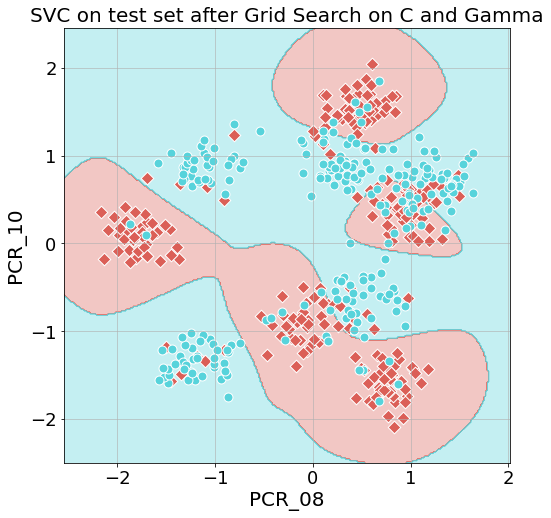

In [154]:
svc.C = best_params['C']
svc.gamma = best_params['gamma']
svc.fit(X_train_rbf, Y_train_rbf)
print(f'accuracy = {svc.score(X_test_rbf, Y_test_rbf)}')
visualize_clf(svc,X_test_rbf,Y_test_rbf,'SVC on test set after Grid Search on C and Gamma', 'PCR_08', 'PCR_10')

In [155]:
C_range = np.concatenate([np.linspace(0.0001, 0.1, 10), [1,10,100,1000,10000]])
gamma_range = [0.0001, 0.001, 0.1, 1, 3, 6, 8, 10 , 100, 1000]
from sklearn.model_selection import cross_validate
train_scores = np.zeros((len(C_range), len(gamma_range)))
test_scores = np.zeros((len(C_range), len(gamma_range)))
for i in range(len(C_range)):
    for j in range(len(gamma_range)):
        svc = SVC(C = C_range[i], gamma = gamma_range[j])
        svc.fit(X_train_rbf,Y_train_rbf)
        return_val = cross_validate(svc, X_test_rbf, Y_test_rbf, cv=8, scoring='accuracy', return_train_score=True)
        train_scores[i,j] = return_val['train_score'].mean()
        test_scores[i,j] = return_val['test_score'].mean()

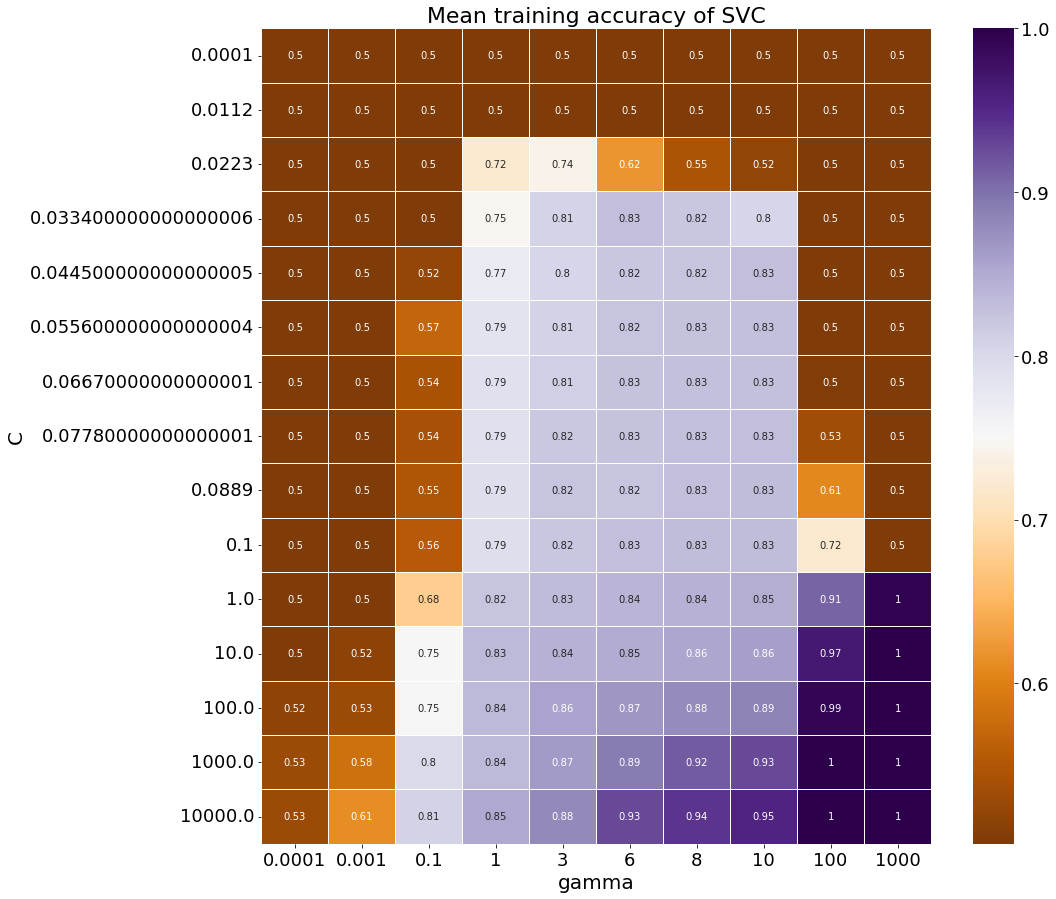

In [156]:
plt.figure(figsize=(15,15))
plt.title('Mean training accuracy of SVC')
s = sns.heatmap(train_scores, annot = True, xticklabels=gamma_range, yticklabels=C_range,linewidths = 1, cmap='PuOr').set(xlabel='gamma', ylabel='C')

Text(0.5, 1.0, 'Mean validation accuracy of SVC')

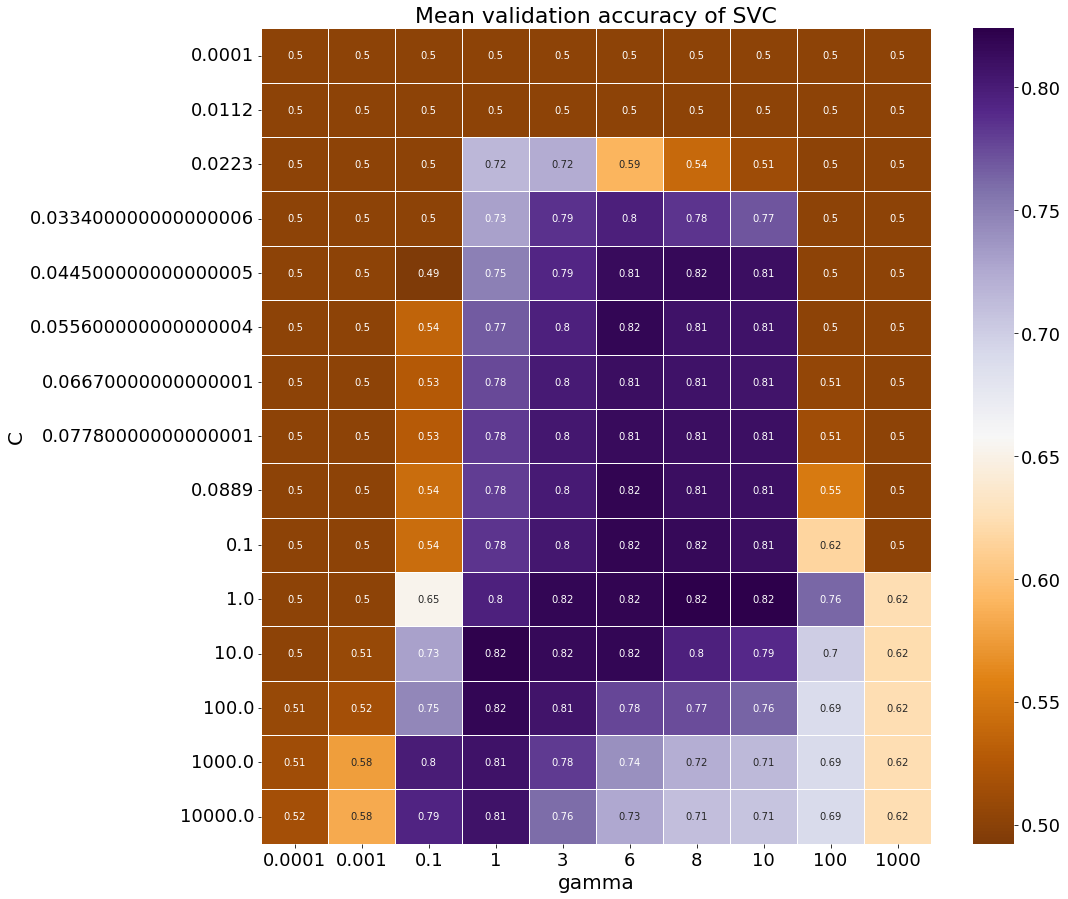

In [157]:
plt.figure(figsize=(15,15))
sns.heatmap(data=test_scores, annot = True, xticklabels=gamma_range, yticklabels=C_range,linewidths = 1, cmap='PuOr').set(xlabel='gamma', ylabel='C')
plt.title('Mean validation accuracy of SVC')

Accuracy of SVC with optimal hyper params on the test set: 0.826


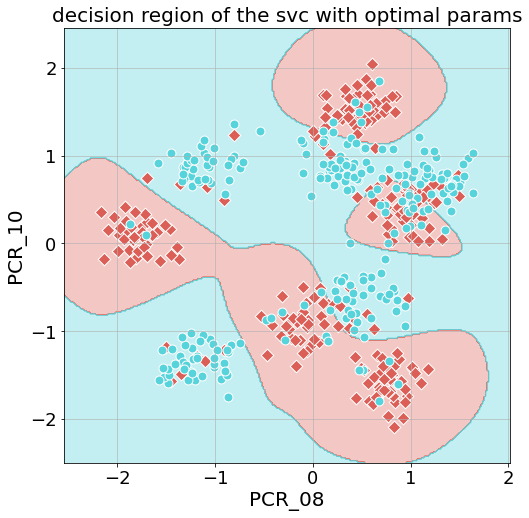

In [158]:
best_svc = SVC(**best_params)
best_svc.fit(X_train_rbf, Y_train_rbf)
print(f'Accuracy of SVC with optimal hyper params on the test set: {best_svc.score(X_test_rbf, Y_test_rbf)}')

visualize_clf(best_svc,X_test_rbf, Y_test_rbf,'decision region of the svc with optimal params', 'PCR_08', 'PCR_10')